# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:23:17.030910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:23:17.030956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:23:17.032427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-9, who has ID: AQYKV5QEAO7P5

In [2]:
parameters = {}

user = "users-9"
user_id = "AQYKV5QEAO7P5"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A2VSU1ZJBMRZDU,B001TY5D6C,B001411SK0,B001411SK0
1,A3LSI954URFAJ3,B000084EEF,B004JBB22G,B015D67968
2,A3PZARP3I8BWZH,B000084EEF,B00WMMMHNM,B00UXY3NM0
3,A3PZARP3I8BWZH,B00UXY3NM0,B007EMTAYE,B00WMMMHNM
4,A19YJWD8OAZX2S,B000084EEF,B01AT89OEA,B018OI4I66
...,...,...,...,...
25396,A1438P64IYC1LG,B019OAIT22,B00O3GWKDM,B00O3GWKL4
25397,A2MCPVRDURR7P2,B01GJJHPLC,B00L9KIY3A,B0018KOHFK
25398,A80KFPCXKV4BQ,B01GJJHPLC,B0075RW2KC,B01GY6OIBU
25399,A1OTIUDE7LWAGT,B01GJJHPLC,B000AU64Q4,B00YS5QFLG


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 25401
Number of sequences and targets after removal: 24905


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            AQYKV5QEAO7P5
productID                B00UXY3NM0
purchased_before_1       B0006N9LKG
purchased_before_2       B000TMTN2U
Name: 1179, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 24904
Number of sequences and targets after dropping duplicates: 24128


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 95
Number of unique product IDs in sequences: 15483


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B001411SK0', 'B001411SK0'],
        ['B004JBB22G', 'B015D67968'],
        ['B00WMMMHNM', 'B00UXY3NM0'],
        ['B007EMTAYE', 'B00WMMMHNM'],
        ['B000QOIX4U', 'B0006G511G'],
        ['B014E2AGYE', 'B004V4BXTI'],
        ['B0002DIRXC', 'B00OILVTES'],
        ['B004XZB0QQ', 'B001TA5O9C'],
        ['B0151JV6MK', 'B017P1QSC0'],
        ['B002CJAOPI', 'B001CGN5PS']], dtype=object),
 array(['B001TY5D6C', 'B000084EEF', 'B000084EEF', 'B00UXY3NM0',
        'B000084EEF', 'B000084EEF', 'B000084EEF', 'B000084EEF',
        'B000084EEF', 'B000084EEF'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[20233, 20233],
        [39213, 125538],
        [115747, 113153],
        [55658, 115747],
        [16286, 7620],
        [124024, 41116],
        [4429, 103905],
        [41871, 27662],
        [125048, 129218],
        [30165, 23503]], dtype=object),
 array([27828, 275, 275, 113153, 275, 275, 275, 275, 275, 275],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 19284
Number of validation sequences: 2423
Number of test sequences: 2421

Number of train targets: 19284
Number of validation targets: 2423
Number of test targets: 2421

Number of classes (unique product IDs) in the train targets: 92
Number of classes in the validation targets: 93
Number of classes in the test targets: 95


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([17392, 56840], dtype=object),
 array([20456, 20456], dtype=object),
 array([25705, 28776], dtype=object),
 array([54966, 105008], dtype=object),
 array([31118, 103908], dtype=object),
 array([33368, 56840], dtype=object),
 array([35379, 6698], dtype=object),
 array([32459, 123288], dtype=object),
 array([124041, 88503], dtype=object),
 array([5870, 125293], dtype=object)]

In [19]:
y_train[:10]

[255, 255, 255, 255, 255, 255, 255, 255, 255, 255]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 27/603 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0825 - f1_score: 0.0677 - f1_score_at_k: 0.1154 - hit_rate_at_k: 0.3156 - loss: 11.8324 - ndcg_at_k: 0.0670                     

I0000 00:00:1714591411.677498    1409 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


603/603 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.0970 - f1_score: 0.0442 - f1_score_at_k: 0.0944 - hit_rate_at_k: 0.3713 - loss: 7.9962 - ndcg_at_k: 0.0794 - val_accuracy: 0.0739 - val_f1_score: 0.0721 - val_f1_score_at_k: 0.2889 - val_hit_rate_at_k: 0.2883 - val_loss: 3.8065 - val_ndcg_at_k: 0.0603
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1272 - f1_score: 0.0749 - f1_score_at_k: 0.1313 - hit_rate_at_k: 0.4222 - loss: 3.4813 - ndcg_at_k: 0.0933 - val_accuracy: 0.0949 - val_f1_score: 0.1068 - val_f1_score_at_k: 0.4157 - val_hit_rate_at_k: 0.3717 - val_loss: 3.6686 - val_ndcg_at_k: 0.0801
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1895 - f1_score: 0.1430 - f1_score_at_k: 0.1975 - hit_rate_at_k: 0.5200 - loss: 3.1827 - ndcg_at_k: 0.1217 - val_accuracy: 0.1263 - val_f1_score: 0.1733 - val_f1_score_at_k: 0.4586 - val_hit_rate_at_k: 0.3945 - val_loss: 3.6047 - val_ndcg_at_k: 0.0894
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - a

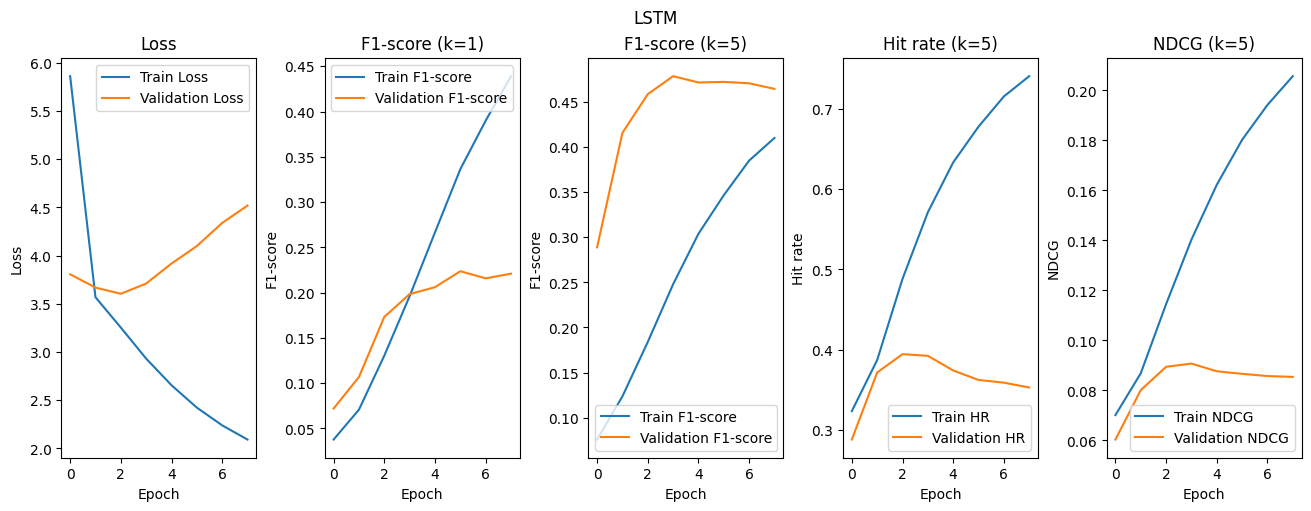

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1394 - f1_score: 0.2120 - f1_score_at_k: 0.4777 - hit_rate_at_k: 0.3562 - loss: 4.2188 - ndcg_at_k: 0.0847
Test loss: 4.5251
Test accuracy: 0.1309
Test F1@1: 0.2
Test F1@5: 0.4463
Test HR@5: 0.3401
Test NDCG@5: 0.0808


In [32]:
parameters

{'user': 'users-9',
 'user_id': 'AQYKV5QEAO7P5',
 'number_of_sequences_and_targets_before_removal': 25401,
 'number_of_sequences_and_targets_after_removal': 24905,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 24128,
 'num_unique_product_ids_in_targets': 95,
 'num_unique_product_ids_in_sequences': 15483,
 'number_of_sequences_and_targets_train': 19284,
 'number_of_sequences_and_targets_validation': 2423,
 'number_of_sequences_and_targets_test': 2421,
 'number_of_unique_products_in_targets_train': 92,
 'number_of_unique_products_in_targets_validation': 93,
 'number_of_unique_products_in_targets_test': 95,
 'model_lstm_test_loss': 4.525065898895264,
 'model_lstm_test_accuracy': 0.1309,
 'model_lstm_test_f1_score_k_1': 0.2,
 'model_lstm_test_f1_score_k_5': 0.4463,
 'model_lstm_test_hr': 0.3401,
 'model_lstm_test_ndcg': 0.0808}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.1046 - f1_score: 0.0595 - f1_score_at_k: 0.0972 - hit_rate_at_k: 0.3707 - loss: 7.5494 - ndcg_at_k: 0.0806 - val_accuracy: 0.0825 - val_f1_score: 0.0960 - val_f1_score_at_k: 0.3237 - val_hit_rate_at_k: 0.3072 - val_loss: 3.7717 - val_ndcg_at_k: 0.0653
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1446 - f1_score: 0.0984 - f1_score_at_k: 0.1456 - hit_rate_at_k: 0.4381 - loss: 3.4022 - ndcg_at_k: 0.0992 - val_accuracy: 0.1094 - val_f1_score: 0.1390 - val_f1_score_at_k: 0.4218 - val_hit_rate_at_k: 0.3725 - val_loss: 3.6154 - val_ndcg_at_k: 0.0816
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2170 - f1_score: 0.1652 - f1_score_at_k: 0.2178 - hit_rate_at_k: 0.5412 - loss: 3.0682 - ndcg_at_k: 0.1304 - val_accuracy: 0.1321 - val_f1_score: 0.1911 - val_f1_score_at_k: 0.4526 - val_hit_rate_at_k: 0.3819 - val_loss: 3.6238 - val_ndcg_at_k: 0.0879
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7

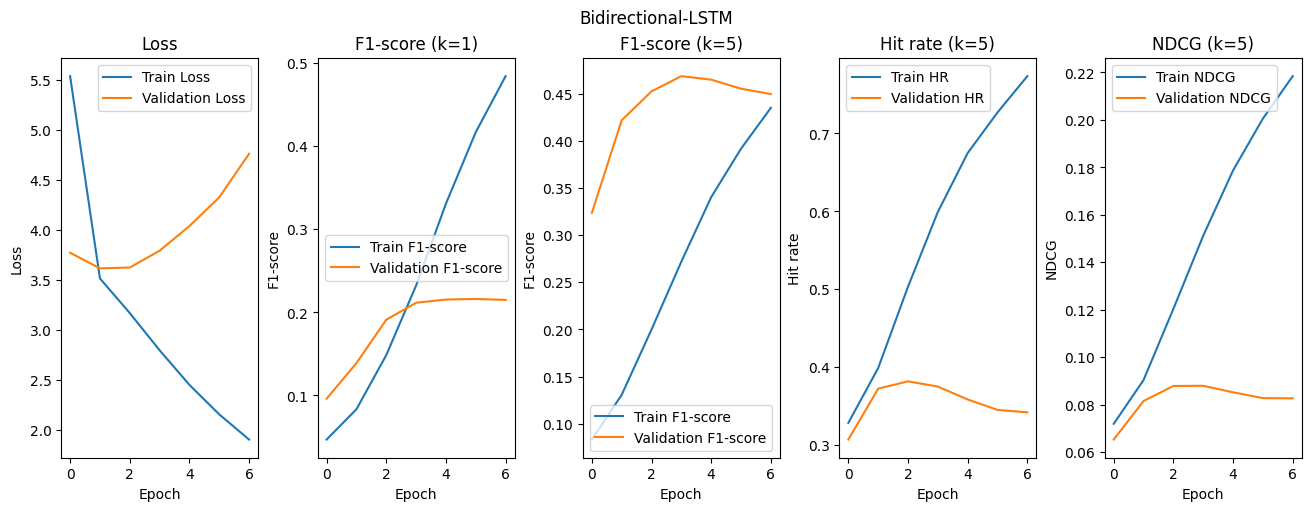

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.1546 - f1_score: 0.2386 - f1_score_at_k: 0.5078 - hit_rate_at_k: 0.3832 - loss: 4.3811 - ndcg_at_k: 0.0917
Test loss: 4.7177
Test accuracy: 0.1371
Test F1@1: 0.2123
Test F1@5: 0.4588
Test HR@5: 0.3489
Test NDCG@5: 0.083


In [37]:
parameters

{'user': 'users-9',
 'user_id': 'AQYKV5QEAO7P5',
 'number_of_sequences_and_targets_before_removal': 25401,
 'number_of_sequences_and_targets_after_removal': 24905,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 24128,
 'num_unique_product_ids_in_targets': 95,
 'num_unique_product_ids_in_sequences': 15483,
 'number_of_sequences_and_targets_train': 19284,
 'number_of_sequences_and_targets_validation': 2423,
 'number_of_sequences_and_targets_test': 2421,
 'number_of_unique_products_in_targets_train': 92,
 'number_of_unique_products_in_targets_validation': 93,
 'number_of_unique_products_in_targets_test': 95,
 'model_lstm_test_loss': 4.525065898895264,
 'model_lstm_test_accuracy': 0.1309,
 'model_lstm_test_f1_score_k_1': 0.2,
 'model_lstm_test_f1_score_k_5': 0.4463,
 'model_lstm_test_hr': 0.3401,
 'model_lstm_test_ndcg': 0.0808,
 'model_bi_lstm_test_loss': 4.717741966247559,
 'model_bi_lstm_test_accuracy': 0.1371,
 'model_bi_lstm_test_f1_score_k_1': 0.2123,
 '

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.0908 - f1_score: 0.0402 - f1_score_at_k: 0.0915 - hit_rate_at_k: 0.3660 - loss: 7.8744 - ndcg_at_k: 0.0770 - val_accuracy: 0.0735 - val_f1_score: 0.0713 - val_f1_score_at_k: 0.3057 - val_hit_rate_at_k: 0.3030 - val_loss: 3.7892 - val_ndcg_at_k: 0.0622
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1277 - f1_score: 0.0736 - f1_score_at_k: 0.1330 - hit_rate_at_k: 0.4158 - loss: 3.4578 - ndcg_at_k: 0.0919 - val_accuracy: 0.1007 - val_f1_score: 0.1182 - val_f1_score_at_k: 0.3535 - val_hit_rate_at_k: 0.3181 - val_loss: 3.7236 - val_ndcg_at_k: 0.0702
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1596 - f1_score: 0.0997 - f1_score_at_k: 0.1634 - hit_rate_at_k: 0.4600 - loss: 3.3500 - ndcg_at_k: 0.1051 - val_accuracy: 0.1036 - val_f1_score: 0.1244 - val_f1_score_at_k: 0.4307 - val_hit_rate_at_k: 0.3754 - val_loss: 3.6232 - val_ndcg_at_k: 0.0822
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6

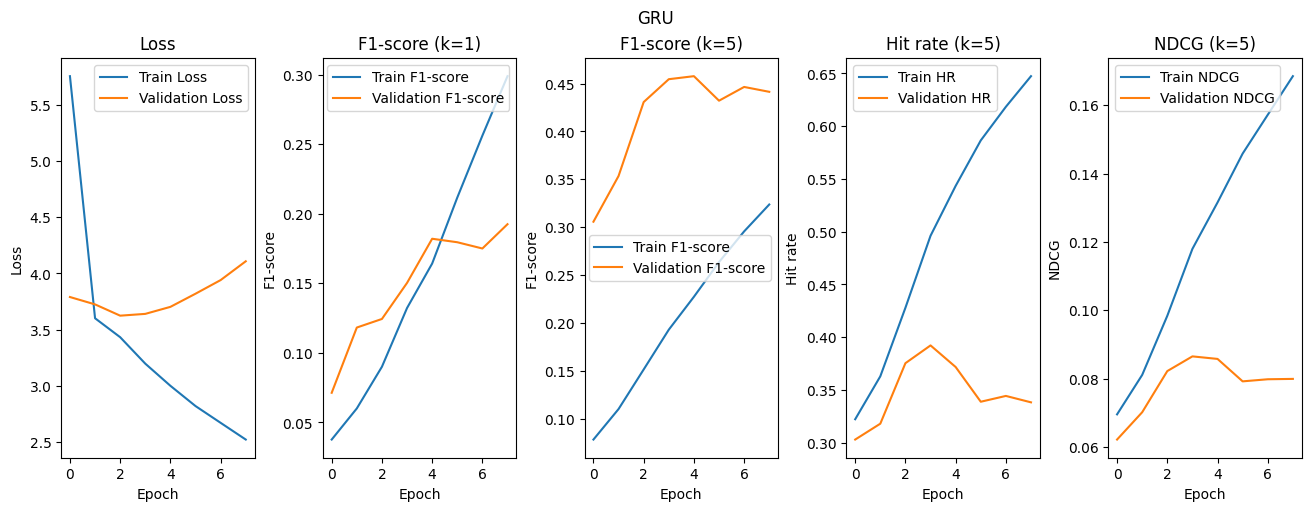

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1363 - f1_score: 0.2114 - f1_score_at_k: 0.4960 - hit_rate_at_k: 0.3781 - loss: 3.8550 - ndcg_at_k: 0.0889
Test loss: 4.1437
Test accuracy: 0.1276
Test F1@1: 0.193
Test F1@5: 0.4472
Test HR@5: 0.3458
Test NDCG@5: 0.0811


In [42]:
parameters

{'user': 'users-9',
 'user_id': 'AQYKV5QEAO7P5',
 'number_of_sequences_and_targets_before_removal': 25401,
 'number_of_sequences_and_targets_after_removal': 24905,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 24128,
 'num_unique_product_ids_in_targets': 95,
 'num_unique_product_ids_in_sequences': 15483,
 'number_of_sequences_and_targets_train': 19284,
 'number_of_sequences_and_targets_validation': 2423,
 'number_of_sequences_and_targets_test': 2421,
 'number_of_unique_products_in_targets_train': 92,
 'number_of_unique_products_in_targets_validation': 93,
 'number_of_unique_products_in_targets_test': 95,
 'model_lstm_test_loss': 4.525065898895264,
 'model_lstm_test_accuracy': 0.1309,
 'model_lstm_test_f1_score_k_1': 0.2,
 'model_lstm_test_f1_score_k_5': 0.4463,
 'model_lstm_test_hr': 0.3401,
 'model_lstm_test_ndcg': 0.0808,
 'model_bi_lstm_test_loss': 4.717741966247559,
 'model_bi_lstm_test_accuracy': 0.1371,
 'model_bi_lstm_test_f1_score_k_1': 0.2123,
 '

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.0598 - f1_score: 0.0395 - f1_score_at_k: 0.0840 - hit_rate_at_k: 0.1970 - loss: 9.7480 - ndcg_at_k: 0.0433 - val_accuracy: 0.0735 - val_f1_score: 0.0718 - val_f1_score_at_k: 0.3110 - val_hit_rate_at_k: 0.3047 - val_loss: 3.7812 - val_ndcg_at_k: 0.0638
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1130 - f1_score: 0.0762 - f1_score_at_k: 0.1274 - hit_rate_at_k: 0.4035 - loss: 3.5610 - ndcg_at_k: 0.0878 - val_accuracy: 0.0875 - val_f1_score: 0.1030 - val_f1_score_at_k: 0.3394 - val_hit_rate_at_k: 0.3154 - val_loss: 3.7157 - val_ndcg_at_k: 0.0684
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1327 - f1_score: 0.0884 - f1_score_at_k: 0.1388 - hit_rate_at_k: 0.4176 - loss: 3.5117 - ndcg_at_k: 0.0934 - val_accuracy: 0.1048 - val_f1_score: 0.1320 - val_f1_score_at_k: 0.4041 - val_hit_rate_at_k: 0.3520 - val_loss: 3.6491 - val_ndcg_at_k: 0.0771
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7

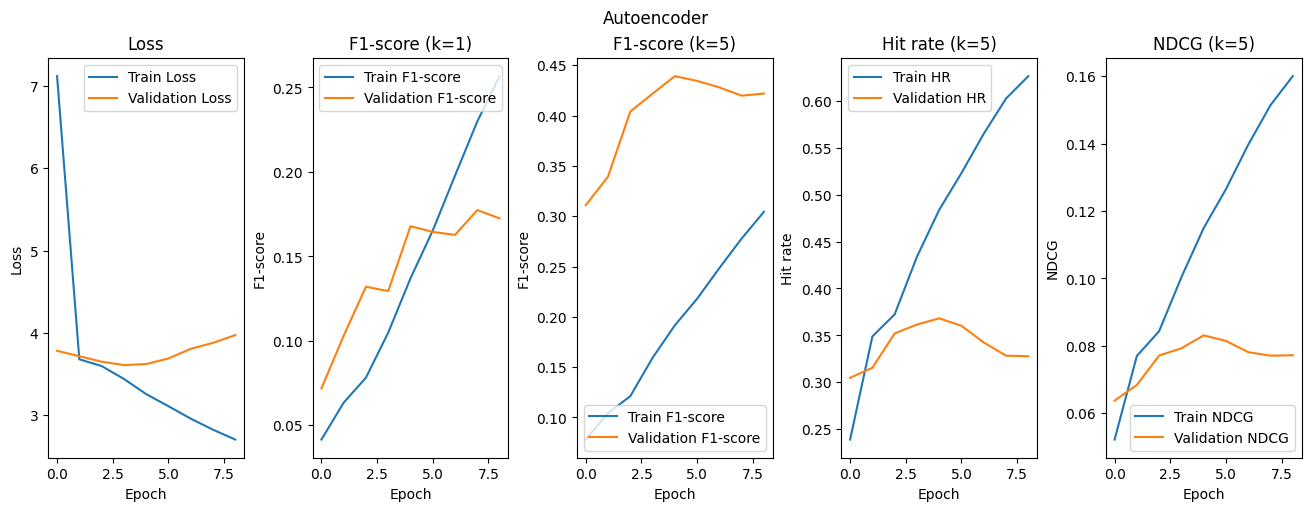

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1148 - f1_score: 0.1753 - f1_score_at_k: 0.4970 - hit_rate_at_k: 0.3853 - loss: 3.7796 - ndcg_at_k: 0.0854
Test loss: 3.9635
Test accuracy: 0.1206
Test F1@1: 0.1824
Test F1@5: 0.4401
Test HR@5: 0.3416
Test NDCG@5: 0.079


In [47]:
parameters

{'user': 'users-9',
 'user_id': 'AQYKV5QEAO7P5',
 'number_of_sequences_and_targets_before_removal': 25401,
 'number_of_sequences_and_targets_after_removal': 24905,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 24128,
 'num_unique_product_ids_in_targets': 95,
 'num_unique_product_ids_in_sequences': 15483,
 'number_of_sequences_and_targets_train': 19284,
 'number_of_sequences_and_targets_validation': 2423,
 'number_of_sequences_and_targets_test': 2421,
 'number_of_unique_products_in_targets_train': 92,
 'number_of_unique_products_in_targets_validation': 93,
 'number_of_unique_products_in_targets_test': 95,
 'model_lstm_test_loss': 4.525065898895264,
 'model_lstm_test_accuracy': 0.1309,
 'model_lstm_test_f1_score_k_1': 0.2,
 'model_lstm_test_f1_score_k_5': 0.4463,
 'model_lstm_test_hr': 0.3401,
 'model_lstm_test_ndcg': 0.0808,
 'model_bi_lstm_test_loss': 4.717741966247559,
 'model_bi_lstm_test_accuracy': 0.1371,
 'model_bi_lstm_test_f1_score_k_1': 0.2123,
 '

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'AQYKV5QEAO7P5', 'sequence': [8362, 17020], 'target': 113153}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 1.0
NDCG@50: 0.014117822982370853
-------------
HT@100: 1.0
NDCG@100: 0.00869624875485897
-------------
HT@200: 1.0
NDCG@200: 0.005229696165770292
-------------
HT@300: 1.0
NDCG@300: 0.0038432308938354254
-------------
HT@400: 1.0
NDCG@400: 0.003075183369219303
-------------
HT@500: 1.0
NDCG@500: 0.00258072791621089
-------------
